# Machine Learning for Single-Cell Biology
***

Winter Semester 2025/26<br />
Manfred Claassen, Maximilian Wirth, Jan Schleicher
<br />
***

## Assignment 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.optimize as opt
import seaborn as sns

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from umap import UMAP

from tqdm.auto import tqdm

sns.set_style("ticks")
%matplotlib inline

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = "data/"

### Task 1

In [3]:
# Load the data
expression_data_1 =  np.loadtxt(os.path.join(DATA_PATH, "expression_data_1.txt"))
metadata_1 = pd.read_csv(os.path.join(DATA_PATH, "metadata_1.txt"), header=None, names=["cell_type"])

In [4]:
def task_01_lle(data: np.array, dim_n: int, k=5) -> np.array:
    """
    This function performs a locally-linear embedding.
    :param data: numpy array of shape (n_samples, n_features)
    :param dim_n: reduced dimensionality
    :param k: number of nearest neighbors
    :return: numpy array of shape (n_samples, dim_n)
    """
    #embedding = np.zeros((data.shape[0], dim_n))

    #########################
    n_samples = data.shape[0]

    # 1) Compute nearest neighbors
    k = min(k, n_samples - 1)

    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # 2) Compute Weight Matrix by reconstruction Xi from k-neighbors
    W = sp.lil_matrix((n_samples, n_samples), dtype=np.float64)
    regularization_tol = 1e-3

    for i in range(n_samples): 
        # extracting original datapoint Xi, and neighboring datapoints Xj to Xi
        Xi = data[i]
        neighbor_indices = indices[i]
        Xj = data[neighbor_indices]

        # Centering datapoints Xj to Xi -> needed for covarianz matrix
        Z = Xj - Xi

        # Computing covarianz matrix with centered data and it's transposed -> reflects the geometrical relations between neighbors -> needed for reconstruction
        C = np.dot(Z, Z.T)

        # Regularization -> Ridge Transformation -> we add the some variance to the main diagonal of the covarianz matrix -> avoid singular covarianz matrix
        C += np.eye(k) * regularization_tol * np.trace(C)

        # Solving the system 
        w = np.linalg.solve(C + 1e-6*np.eye(k), np.ones(k))

        # Norming the weights -> ensuring the constraint is fullfilled -> weights only add up to 1
        w /= np.sum(w)

        W[i, neighbor_indices] = w

    W = W.tocsr()

    # 3) Embedding -> computing Yi, by solving eigenvalue problem
    I = sp.identity(n_samples, dtype=float)
    M = (I-W).T.dot(I-W)

    k_eigenvectors = dim_n + 1
    eigenvalues, eigenvectors = eigsh(M, k=k_eigenvectors, which='SM')

    #4) Sorting eigenvectors
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:, index]

    embedding = eigenvectors[:, 1:k_eigenvectors]

    
    #########################

    return embedding

### Task1A - Step by Step description of the LLE algorithm

1. **Neighborhood Selection:** In the first step, we assign neighbors to each data point X, for example using k-nearest neighbors algorithm

2. **Weight Matrix Construction:** Next we compute the weights, that best linearly construct each data point X from its neighbors, by solving the constraint least-squares problem. 
This preserves the local relationships

3. **Output Embedding:** In the last step we compute low-dimensional embedding vectors Y, by using linear algebra do reduce reconstruction error. This minimization is achieved by finding the smallest eigenvectors of a sparse matrix. 


array([[-0.00102747, -0.01038743],
       [-0.00102747,  0.05030083],
       [-0.00102747, -0.01039095],
       ...,
       [-0.00102747,  0.05151981],
       [-0.00102747,  0.05001903],
       [-0.00102747, -0.01038481]], shape=(2638, 2))

array([-0.00102747, -0.00102747, -0.00102747, ..., -0.00102747,
       -0.00102747, -0.00102747], shape=(2638,))

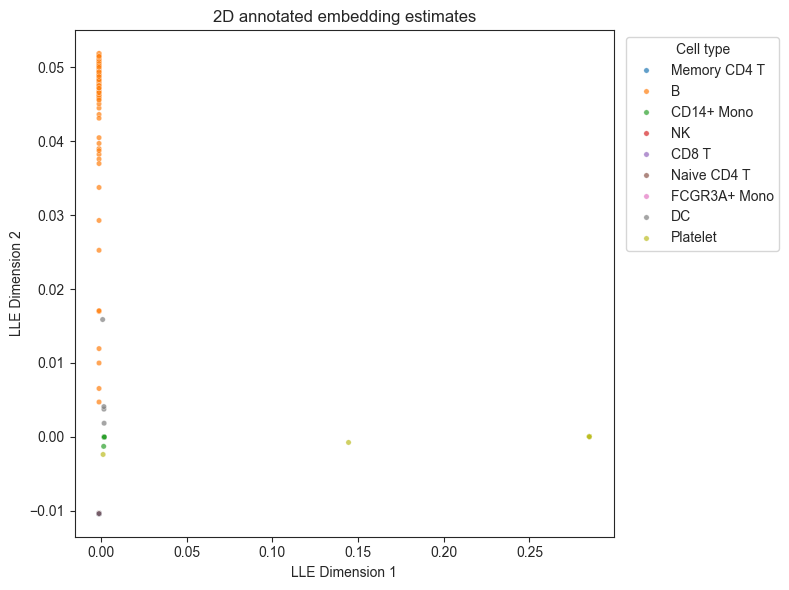

In [5]:
# Task 1A
# Compute locally linear embedding for given data
task_01_solution = task_01_lle(data=expression_data_1, dim_n=2)
display(task_01_solution)

display(task_01_solution[:,0])
# Plot the embedding, annotated with cell type identity
#########################
#x_values = task_01_solution[:,0]
#y_values = task_01_solution[:,1]


df_annotated = pd.DataFrame(
    task_01_solution,
    columns=["LLE1", "LLE2"]
)

df_annotated["Cell_Type"] = metadata_1


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data = df_annotated,
    x = "LLE1", 
    y = "LLE2",
    hue="Cell_Type",
    s = 15,
    alpha = 0.7
)

plt.title("2D annotated embedding estimates")
plt.xlabel("LLE Dimension 1")
plt.ylabel("LLE Dimension 2")

plt.legend(
    title = 'Cell type',
    loc ='upper left', 
    bbox_to_anchor=(1.01, 1),
    frameon = True
)

plt.tight_layout()
plt.show()
#########################

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


0       Memory CD4 T
1                  B
2       Memory CD4 T
3         CD14+ Mono
4                 NK
            ...     
2633      CD14+ Mono
2634               B
2635               B
2636               B
2637     Naive CD4 T
Name: Cell_Type, Length: 2638, dtype: object

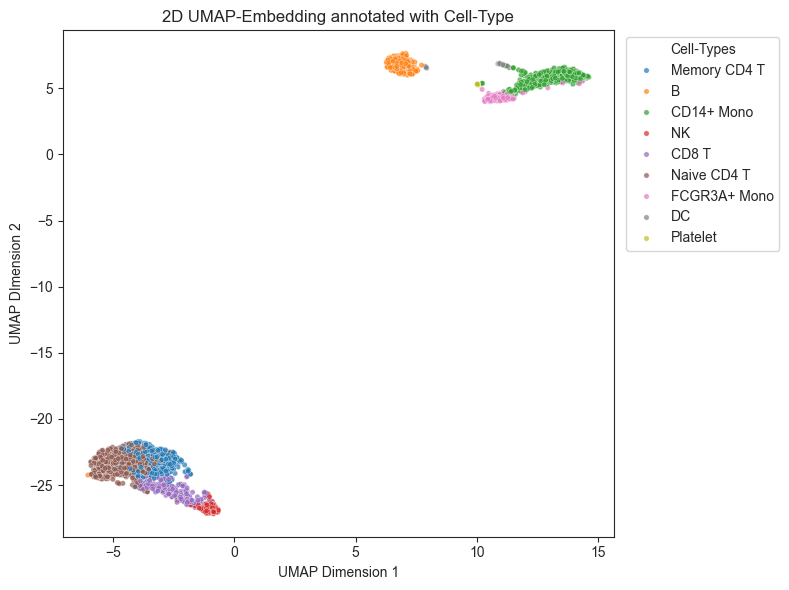

In [6]:
# Task 1B
# Compute UMAP embedding of the given data and plot it
#########################
umap = UMAP(n_components=2, random_state=42)
umap_embedding = umap.fit_transform(expression_data_1)

df_umap = pd.DataFrame(
    umap_embedding, 
    columns = ["UMAP1", "UMAP2"]
)

df_umap["Cell_Type"] = metadata_1

display(df_umap["Cell_Type"])

plt.figure(figsize=(8, 6))

sns.scatterplot(
    data = df_umap,
    x = "UMAP1",
    y = "UMAP2",
    hue = "Cell_Type",
    s = 15,
    alpha = 0.7
)

plt.title("2D UMAP-Embedding annotated with Cell-Type")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP DImension 2")

plt.legend(
    title = "Cell-Types",
    loc = "upper left",
    bbox_to_anchor = (1.01,1),
    frameon = True
)

plt.tight_layout()
plt.show()
#########################

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\

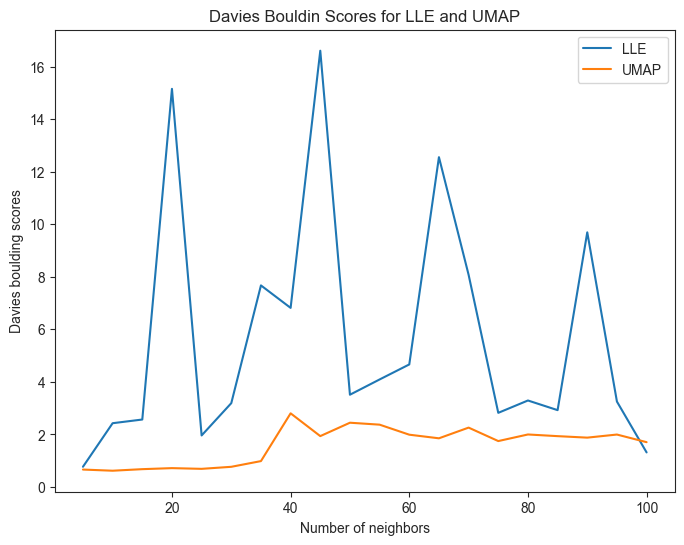

In [7]:
# Task 1C
# Compute LLE and UMAP embeddings with different numbers of neighbors
#########################
results = []
cell_types = metadata_1

for i in range(5, 101, 5): 
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=i, random_state=42)
    lle_embedding = lle.fit_transform(expression_data_1)
    
    umap = UMAP(n_components=2, n_neighbors=i, random_state=42)
    umap_embedding = umap.fit_transform(expression_data_1)

    # compute similarity with davies_bouldin_score -> less intracluster variance and more intercluster variance leads to higher score (more similarity)
    lle_davies_bouldin_score = davies_bouldin_score(lle_embedding, cell_types)
    umap_davies_bouldin_score = davies_bouldin_score(umap_embedding, cell_types)

    results.append([i, lle_davies_bouldin_score, umap_davies_bouldin_score])

results_df = pd.DataFrame(results, columns=["n_neighbors", "LLE_DB", "UMAP_DB"])

plt.figure(figsize=(8,6))

sns.lineplot(data = results_df, x = "n_neighbors", y = "LLE_DB", label="LLE")
sns.lineplot(data = results_df, x = "n_neighbors", y = "UMAP_DB", label="UMAP")

plt.title("Davies Bouldin Scores for LLE and UMAP")
plt.xlabel("Number of neighbors")
plt.ylabel("Davies boulding scores")
plt.show()


#########################

**Provide your text answers for Task 1D here**

##### **What are the differences between the two embeddings?**
- While **LLE** tries to approximate local relationships of datapoints, by reconstructing a datapoints through a linear combination of its neighbors, 
  **UMAP** first approximates a fuzzy topology in form of a graph of neighbors, which is later mapped to a lower dimensional graph.
- This helps **UMAP** to localy reconstruct datapoints in lower dimensions, while keeping some globaly information about the clusters too. This makes **UMAP** the prefered method for visualizations
- **LLE** is a more theoretical, but instable approach, since, it tries reconstruct a certain datapoint by linear combinations, of its neighbors. Noisy data can easily lead to destabilization of these linear combinations. Also only local reconstruction is possible, global clustering is not feasible ==> not prefered choise for practical analysis or visualizations
- For **LLE** the number of neighbors k, does matter and influence the performance of clustering: low numbers lead to fragmentation, high numbers to unclear clustering 

##### **Which embedding is better suited to visualize cell populations and why?**

This point was already described above. LLE, is only able to reconstruct local datapoints based on given neighbors. Noise leads to less clear clustering of the given datapoints (gene expression values of cells), fluctuating with the number of chosen k neighbors. UMAP is capable of not only capturing local reconstruction of clusters, but also captures some global structures in the first fuzzy topolgy generation. This helps more visualy understanding cell clusters. Also UMAP is more robust against noise, which is helpful for scRNA-seq appraoaches. Its visualization has more clear structure. 

- This can be seen in the comparison of the LLE plot of Task 1A and the UMAP plot of Task 1B

##### **Based on your plots, what do you think are the conceptual differences between the two embedding techniques?**

- For **LLE** we can see, that is not designed for visualization tasks, but rather more tries to solve an linear equation using the number of neighbouring points to compute clusters. 
- The plot in **Task1c** shows, that the **Davies_Bouldin_Score** (which is a measure of similarity, increasing, when intravariance is low and intervariance is high) has high fluctuations choosing different number of neighbors k. But overall has a higher similarity score, than the UMAP method. 
- **UMAP** on the other hand, seems to have lower similarity scores, than **LLE**, but seems to perform better, when it comes to visualizations as can be seen in **Task1b** and also has less fluctuations, when choosing different number of neighbors k, showing it is more robust to noise. This may be, because, the UMAP approach, uses a more geometrical approach, first generating a fuzzy topolgy using neighbor-graphs, and later mapping this graph down to lower dimensions, not loosing global structures, which makes it more robust to noise such as outliers. 

### Task 2

In [8]:
# Load data
expression_data_2 = pd.read_csv(os.path.join(DATA_PATH, "expression_data_2.txt"), sep="\t", index_col=0)
metadata_2 = pd.read_csv(os.path.join(DATA_PATH, "metadata_2.txt"), sep="\t", index_col=0)

In [9]:
def task_02_quantile_normalization(data: pd.DataFrame, meta_data: pd.DataFrame, target: str) -> pd.DataFrame:
    """
    This function performs quantile normalization as batch correction.
    :param data: pandas DataFrame of shape (n_cells, n_genes)
    :param meta_data: pandas DataFrame containing the target variable to correct for
    :param target: target variable in meta_data
    :return: pandas DataFrame with quantile normalized data
    """
    corrected_data = data.copy()

    #########################
    groups = meta_data[target].astype(str).unique()

    for g in groups:
        # select cells in this group
        cells_in_g = meta_data.index[meta_data[target].astype(str) == g]
        subset = data.loc[cells_in_g, :].values  
       
        # 1. sort each cell's gene values
        sorted_per_cell = np.sort(subset, axis=1)

        # 2. compute mean for group
        mean_sorted = np.mean(sorted_per_cell, axis=0)
        
        # 3. Replace values in each cell with the corresponding mean value based on their rank
        for idx, cell in enumerate(cells_in_g):
            vals = subset[idx]
            ranks_1based = pd.Series(vals).rank(method='average', ascending=True).values
            pos = ranks_1based - 1.0  # convert to 0-based
            pos = np.clip(pos, 0.0, subset.shape[1] - 1)

            low_idx = np.floor(pos).astype(int)
            high_idx = np.ceil(pos).astype(int)
            weight_high = pos - low_idx

            low_vals = mean_sorted[low_idx]
            high_vals = mean_sorted[high_idx]
            mapped = (1.0 - weight_high) * low_vals + weight_high * high_vals

            corrected_data.loc[cell, :] = mapped
    #########################

    return corrected_data

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


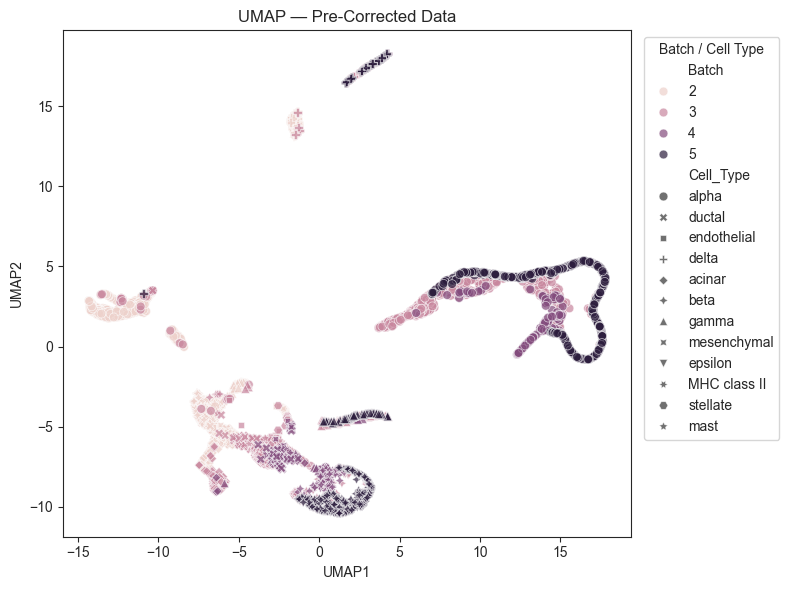

c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Anwender\Desktop\Uni_Tuebingen\Master\1. Semester\ML Single Cell\Assignments\Assignment02\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


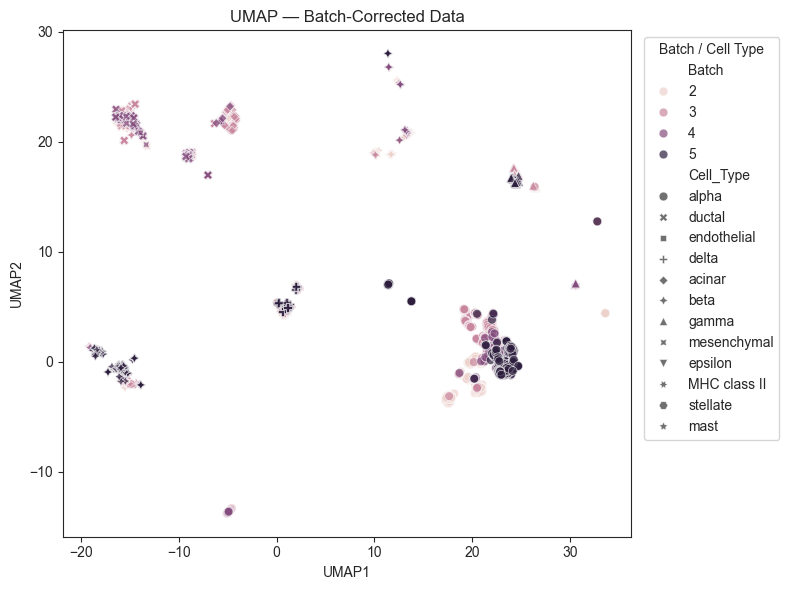

In [10]:
# Task 2
task_02_solution = task_02_quantile_normalization(data=expression_data_2, meta_data=metadata_2, target="celltype")

# Compute UMAP and plot uncorrected and corrected data with batch and celltype annotation
#########################
def plot_umap(data, metadata, title):
    umap_model = UMAP(n_components=2, random_state=42)
    embedding = umap_model.fit_transform(data)

    df_umap = pd.DataFrame(
        embedding,
        columns=["UMAP1", "UMAP2"],
        index=data.index
    )


    df_umap["Batch"] = metadata["batch"]
    df_umap["Cell_Type"] = metadata["celltype"]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_umap,
        x="UMAP1",
        y="UMAP2",
        hue="Batch",      
        style="Cell_Type", 
        s=40,
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.legend(bbox_to_anchor=(1.01,1), loc="upper left", frameon=True, title="Batch / Cell Type")
    plt.tight_layout()
    plt.show()

# Plot pre-corrected data 
plot_umap(expression_data_2, metadata_2, "UMAP — Pre-Corrected Data")

# Plot batch-corrected data 
plot_umap(task_02_solution, metadata_2, "UMAP — Batch-Corrected Data")
#########################

**Provide your text answers for Task 2B here**

The UMAP plots show that batch effects are reduced after correction. This is because cells from different batches mix more effectively. And the main cell types remain well separated, indicating that biological variation is preserved. As a result, the batch correction appears satisfactory.